Assignment 3: 

Name: **Ashutosh Reddy Atimyala**

UID: **118442129**

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: **Ashutosh Reddy Atimyala**

In [2]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow ## Use this to show image in colab
%matplotlib inline

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

In [81]:
# Load Keypoints
from random import sample

x1 = (c1[matches[:,0]-1])
y1 = (r1[matches[:,0]-1])
x2 = (c2[matches[:,1]-1])
y2 = (r2[matches[:,1]-1])

## Helper Functions

In [ ]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow
from ast import Lt

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()


### Code (15 pt)

In [277]:
def ransacF(pts1, pts2,itr):

    final_inliers = None
    max_inliers = 0
    F_est = None
    for i in range(itr):

        # idx = np.random.permutation(pts1.shape[1])[:8]
        idx = random.sample(range(pts1.shape[1]), 8)
        F = computeF(pts1[:,idx], pts2[:,idx])
        
        inliers = getInliers(pts1, pts2, F, 3)
        num_inliers = inliers[0].shape[0]
        
        if max_inliers < num_inliers:
            final_inliers = inliers
            F_est = F
            
    return F_est, final_inliers

def getInliers(pts1, pts2, F, threshold=0.8):
    
    epi1 = np.dot(F.T, pts2)
    epi2 = np.dot(F, pts1)

    dst1,dst2 = [],[]
    for i in range(epi1.shape[1]):
        d1 = abs(np.dot(pts2[:,i].T, epi1[:,i]))
        dst1.append(d1)
        d2 = abs(np.dot(pts1[:,i].T, epi2[:,i]))
        dst2.append(d2)
    dst1 = np.asarray(dst1)
    dst2 = np.asarray(dst2)
    inliers = np.where(dst1 +dst2 < threshold)
    
    return inliers

def normalize(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    S = np.sqrt(2/(x_mean**2 + y_mean**2)) 
    T = np.array([[S, 0, -S*x_mean],
                  [0, S, -S*y_mean],
                  [0, 0, 1]])
    return T

def computeF(pts1, pts2):
    
    T1 = normalize(pts1[0,:],pts1[1,:])
    pts1 = np.dot(T1, pts1)

    T2 = normalize(pts2[0,:], pts2[1,:])
    pts2 = np.dot(T2, pts2)

    A_mat = getMatrixA(pts1, pts2)
    _,_,V = np.linalg.svd(A_mat, full_matrices=True)
    F = V.T[:,-1].reshape(3,3)
    
    U,W,V = np.linalg.svd(F, full_matrices=True)
    W[2] = 0
    F = np.dot(U, np.dot(np.diag(W), V))

    F = np.dot(T2.T, np.dot(F, T1))
    F = F / F[2,2]
    return F


def getMatrixA(A, B):
    rand_idx = np.random.randint(0, len(A), size=8)
    matrix_A = np.array([(A[0, rand_idx]*B[0, rand_idx]).T, 
                         (A[0, rand_idx]*B[1, rand_idx]).T,
                         (A[0, rand_idx]).T,
                         (A[1, rand_idx]*B[0, rand_idx]).T,
                         (A[1, rand_idx]*B[1, rand_idx]).T,
                         (A[1, rand_idx]).T,
                         (B[0, rand_idx]).T,
                         (B[1, rand_idx]).T,
                         np.ones(8).T]).T
    return matrix_A

def plot_epipolar_line(img1, img2, F, x1, x2):
    rand_pt_idx = random.sample(range(x1.shape[1]), 7)

    pts1 = x1[:2,rand_pt_idx]
    lines1 = np.dot(F.T, x2)[:,rand_pt_idx]
    
    pts2 = x2[:2,rand_pt_idx]
    lines2 = np.dot(F, x1)[:,rand_pt_idx]

    c = img1.shape[1]
    for i in range(lines1.shape[1]):
        color = tuple(np.random.randint(0,255,3).tolist())

        x_1, y_1 = map(int, [0, -lines1[2,i] / lines1[1,i]])
        x_2, y_2 = map(int, [c, -(c*lines1[0,i] + lines1[2,i]) / lines1[1,i]])    
        img1 = cv2.line(img1, (x_1, y_1), (x_2, y_2), color,2)
        ptx, pty = pts1.T[i].astype(np.int32)
        img1 = cv2.circle(img1,(ptx, pty),5,color,-1)

        X_1, Y_1 = map(int, [0, -lines2[2,i] / lines2[1,i]])
        X_2, Y_2 = map(int, [c, -(c*lines2[0,i] + lines2[2,i]) / lines2[1,i]])        
        img2 = cv2.line(img2, (X_1, Y_1), (X_2, Y_2), color,2)
        Ptx, Pty = pts2.T[i].astype(np.int32)
        img2 = cv2.circle(img2,(Ptx, Pty),5,color,-1)

    img_out = np.zeros((img2.shape[0], img1.shape[1]+img2.shape[1],3), dtype=np.float32)
    img_out[0:272, 0:512] = img1
    img_out[0:272, 512:512*2] = img2
    cv2_imshow(img_out)

Estimated Fundamental Matrix F after Normalizing to unit length:
 [[ 1.06005131e-05  2.03959132e-05 -2.76718312e-03]
 [-4.96932315e-06  5.46732017e-05 -4.39767877e-03]
 [-2.38640131e-03 -8.84440252e-03  1.00000000e+00]]


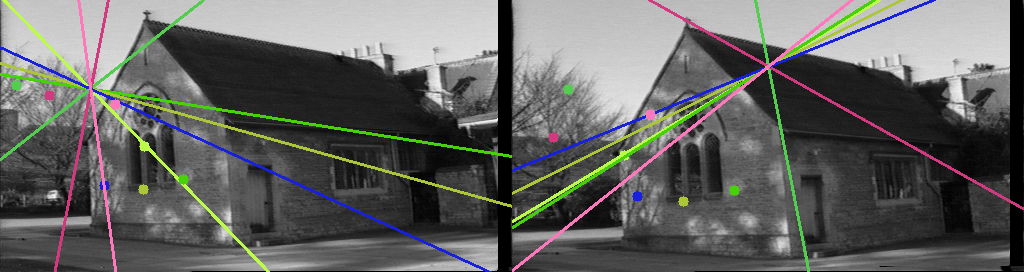

In [324]:
img1 = cv2.imread('/content/Part1_data/chapel00.png')
img2 = cv2.imread('/content/Part1_data/chapel01.png')

ones = np.ones((1, x1.shape[0]))
pts1 = np.vstack((x1.T, y1.T, ones))
pts2 = np.vstack((x2.T, y2.T, ones))

F_est,_= ransacF(pts1, pts2,itr=15000)
print('Estimated Fundamental Matrix F after Normalizing to unit length:\n', F_est)
plot_epipolar_line(img1, img2, F_est, pts1, pts2)

### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.
*   Display the estimated fundamental matrix F after normalizing to unit length
*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



**Write-up:**

1. For a pair of matchpoints to be considered as inlier, the sum of the distances from the respective epipolar lines should be lessthan the threshold where the distances are calculated, using the line-point distance formula,between the matchpoint in imageB to its respective epipolar line which is computed by the correspoing matchpoint in imageA and vice versa.

### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


# Part 2: Image stitching (30 points)

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


## Helper Functions

In [325]:
import cv2
def geometricalDistance(pairs,H):
  pt1 = np.transpose(np.array([pairs[0],pairs[1],1]))
  est_pt2 = np.dot(H,pt1)
  est_pt2 = (1/est_pt2[2]) * est_pt2

  pt2 = np.transpose(np.array([pairs[2],pairs[3],1]))
  est_pt1 = np.dot(H,pt2)
  est_pt1 = (1/est_pt1[2]) * est_pt1
  error1 = pt1 - est_pt1
  error2 = pt2 - est_pt2

  return np.linalg.norm(error2)

def homography(pairs):
  A = []
  for i in range(pairs.shape[0]):
    u = np.array([pairs[i,0],pairs[i,1],1])
    v = np.array([pairs[i,2],pairs[i,3],1])

    a1 = [-u[0], -u[1], -u[2], 0, 0, 0, u[0]*v[0], u[1]*v[0], v[0]]
    a2 = [0, 0, 0, -u[0], -u[1], -u[2], u[0]*v[1], u[1]*v[1], v[1]]
    A.append(a1)
    A.append(a2)

  A = np.array(A)
  U,S,V = np.linalg.svd(A)
  H = np.reshape(V[8], (3,3))
  H = H/H[2,2]
  return H    

def ransac(matches,threshold,max_itr):
  max_inliners = []
  final_H = None
  for i in range(max_itr):
    pairs = [matches[i] for i in np.random.choice(len(matches), 4)]
    pairs = np.asarray(pairs)
    H = homography(pairs)
    inliers = []
    for i in range(pairs.shape[0]):
      dst = geometricalDistance(pairs[i],H)
      if dst<threshold:
        inliers.append(pairs[i])
    if len(inliers) > len(max_inliners):
      max_inliners = inliers
      final_H = H
    if len(max_inliners) > ((pairs.shape[0])*threshold):
      break
  return final_H, max_inliners

### Code (15 pt)

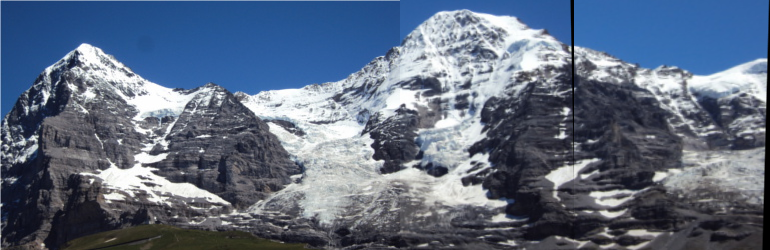

In [332]:
def image_stitching(img1,img2,img3):
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY),None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY),None)
    kp3, des3 = sift.detectAndCompute(cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY),None)

    bf = cv2.BFMatcher()

    matches= bf.knnMatch(des2,des3, k=2)

    good = []
    for m in matches:
      if (m[0].distance < 0.7*m[1].distance):
        good.append(m)
    matches = np.asarray(good)

    if (len(matches[:,0]) >= 4):
        img_l = np.float32([ kp2[m.queryIdx].pt for m in matches[:,0] ])
        img_r = np.float32([ kp3[m.trainIdx].pt for m in matches[:,0] ])
        matches_pairs = np.hstack((img_l,img_r)).reshape(-1,4)
        H,_ = ransac(matches_pairs,1,10000)
    else:
        print('Not Enough Keypoints!')
    warp1 = cv2.warpPerspective(img2,H,((img2.shape[1] + img1.shape[1]), img1.shape[0])) 
    
    warp1[0:img2.shape[0], 0:img2.shape[1]] = img2
    warp1[0:img1.shape[0], 0:img1.shape[1]] = img1
    intermediate_output = warp1[0:300,0:574,:]

    key_points3, descriptor_3 = sift.detectAndCompute(intermediate_output,None)

    matches2 = bf.knnMatch(des1,descriptor_3, k=10)

    good2 = []
    for m in matches2:
        if (m[0].distance < 0.7*m[1].distance):
            good2.append(m)
    matches2 = np.asarray(good2)

    if (len(matches2[:,0]) >= 4):
        img_l = np.float32([ kp1[m.queryIdx].pt for m in matches2[:,0] ])
        img_r = np.float32([ key_points3[m.trainIdx].pt for m in matches2[:,0] ])
        matches_pairs = np.hstack((img_l,img_r)).reshape(-1,4)
        H,_ = ransac(matches_pairs,1,5000)

        
    else:
        print('Not Enough Keypoints!')
    warp2 = cv2.warpPerspective(img3,H,((img3.shape[1] + intermediate_output.shape[1]), intermediate_output.shape[0]))
    warp2[0:img3.shape[0], 0:img3.shape[1]] = img3
    warp2[0:intermediate_output.shape[0], 0:intermediate_output.shape[1]] = intermediate_output
    result = warp2[0:250,0:770,:]

    return result

img1=cv2.imread('/content/hill/1.JPG')
img2=cv2.imread('/content/hill/2.JPG')
img3=cv2.imread('/content/hill/3.JPG')

result = image_stitching(img1,img2,img3)
cv2_imshow(result)


### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC 
*  Display the best homography H after RANSAC 
*  Display the blended images

**Write-up:**  
In order to remove incorrect matches with RANSAC, primarily, the estimated keypoint of the imageB is calculated withrepect to the keypoint in imageA and vice versa. Then, the errors between the keypoints of the image and the estimated keypoints of the image are computed. Finally, if the L2 norm of sum of the errors is greater then the threshold, then these keypoints are considered as incorrect matches.

### Hint


*   Use Harris Corner Detection to find keypoint. You can use cv2.cornerHarris in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv. 


# Part 3: Affine Structure from Motion (40 points)

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

### Code (20 pt)

In [266]:
track_x = data['track_x']
track_y = data['track_y']

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints

  '''
  #Removing nan values
  track_x = (x[~np.isnan(x).any(axis=1)]).T
  track_y = (y[~np.isnan(x).any(axis=1)]).T

  track_x = track_x - np.mean(track_x, axis=1, keepdims=True)
  track_y = track_y - np.mean(track_y, axis=1, keepdims=True)

  # Constructing matrix D
  D = np.vstack((track_x, track_y))
  U,W,Vt = np.linalg.svd(D)
  U = U[:,:3]
  W = np.diag(W[:3])
  V = Vt[:3,:]
  
  #A-camera poses
  #X-3D points
  A =  np.dot(U,np.sqrt(W))  
  X =  np.dot(np.sqrt(W),V)
  
  y_values = A[int(A.shape[0]/2):,:]
  x_values = A[:int(A.shape[0]/2),:]

  #ORthographic COnstraints
  affine_eq1 = np.empty((int(A.shape[0]/2), 9))
  affine_eq2 = np.copy(affine_eq1)
  affine_eq3 = np.copy(affine_eq1)
  
  for i in range(int(A.shape[0]/2)):
    affine_eq1[i] = (np.dot(y_values[[i],:].T,x_values[[i],:])).flatten()
    affine_eq2[i] = (np.dot(x_values[[i],:].T,x_values[[i],:])).flatten()   
    affine_eq3[i] = (np.dot(y_values[[i],:].T,y_values[[i],:])).flatten()

  affine_eqs = np.vstack((affine_eq1, affine_eq2, affine_eq3))
  aff = np.hstack((np.asarray([0]*int(A.shape[0]/2)),np.asarray([1]*A.shape[0])))

  L = np.dot(np.linalg.pinv(affine_eqs),aff)  
  C = np.linalg.cholesky((L.reshape(3,3)))
  A = np.dot(A,C)
  X = np.dot(np.linalg.inv(C),X)
 
  return A,X


cam_est, pts_est = affineSFM(track_x, track_y)

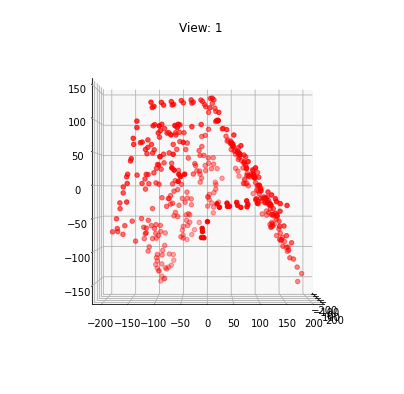

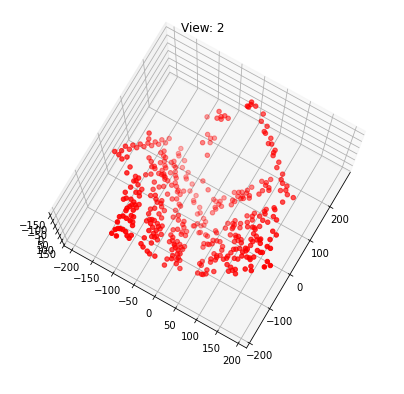

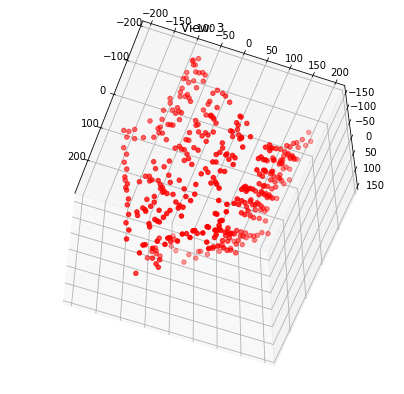

In [267]:
  fig = plt.figure()
  fig.set_size_inches(7, 7)
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(pts_est[0, :], pts_est[1, :], pts_est[2, :], color='r', marker='o')
  ax.set_title('View: 1 ')
  ax.view_init(elev=0, azim=0)
  plt.show()

  fig = plt.figure()
  fig.set_size_inches(7, 7)
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(pts_est[0, :], pts_est[1, :], pts_est[2, :], color='r', marker='o')
  ax.set_title('View: 2')
  ax.view_init(elev=-100, azim=-30)
  plt.show()

  fig = plt.figure()
  fig.set_size_inches(7, 7)
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(pts_est[0, :], pts_est[1, :], pts_est[2, :], color='r', marker='o')
  ax.set_title('View: 3')
  ax.view_init(elev=-240, azim=20)
  plt.show()

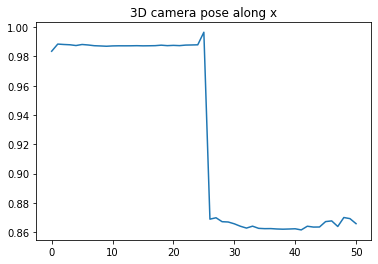

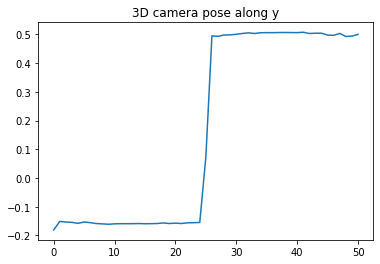

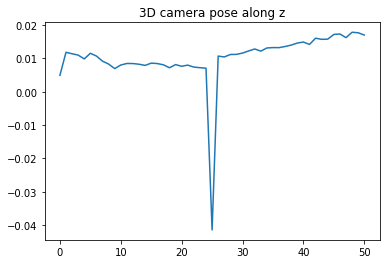

In [268]:
camera_pose = np.zeros((cam_est.shape[0] // 2, cam_est.shape[1]))

cam_est_mean = np.mean(cam_est, axis=0)
cam_est[:, 0] = cam_est[:, 0] / cam_est_mean[0]
cam_est[:, 1] = cam_est[:, 1] / cam_est_mean[1]
cam_est[:, 2] = cam_est[:, 2] / cam_est_mean[2]

for i in range(camera_pose.shape[0]):
  a_k = np.cross(cam_est[(i *2), :], cam_est[(i * 2) + 1, :])
  camera_pose[i, :] = np.divide(a_k, np.linalg.norm(a_k)) 

plt.title('3D camera pose along x')
plt.plot(camera_pose[:, 0])
plt.show()

plt.title('3D camera pose along y')
plt.plot(camera_pose[:, 1])
plt.show()

plt.title('3D camera pose along z')
plt.plot(camera_pose[:, 2])
plt.show()

### Write-up (20 pt)


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints. 
*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992